# Stochastic Discrete Model
## Utility Matrix Calculation and Usage

In [6]:
import copy
from typing import List

import numpy as np
import sys
import seaborn as sb
import random as random
import networkx as nx
import matplotlib.pyplot as plt
from environment.stochastic_environment import StochasticEnvironment
from utils.point import Point
from environment.robots.basic_robot import BasicRobot
from utils.functions import show_grid
from environment.agents.stochastic_agent import StochasticAgent

### initial state (lowest layer of the 3d position matrix PM)

In [13]:
b, br = 10, 10
advance_distribution = (0.2, 0.6, 0.2)

agents = [StochasticAgent(Point(3,2),1, advance_distribution),
          StochasticAgent(Point(5,2),1, advance_distribution),
          StochasticAgent(Point(6,8),1, advance_distribution),
          StochasticAgent(Point(8,4),1, advance_distribution)]

robots = [BasicRobot(Point(1,1),2,1),
          BasicRobot(Point(2,0),2,1),
          BasicRobot(Point(4,1),2,1)]

### calculating the position matrix PA

In [25]:
def generate_PA():
    left, up, right = advance_distribution
    top_border, right_border = b, br

    # init 3d matrix of grid rows, cols and time
    PA = np.zeros((top_border, top_border, right_border))

    # in t=0 we have prob. 1 of being in the initial loc
    for agent in agents:
        PA[0][int(agent.y)][int(agent.x)] = 1

    # filling the rest times by dp
    T = int(top_border)
    num_rows = int(top_border)
    num_cols = int(right_border)

    for t in range(1, T):
        # fill the rows by dp
        for row in range(1, num_rows):
            # handle extreme cells
            PA[t][r][0] = (left + up) * PA[t - 1][r - 1][0] + left * PA[t - 1][r - 1][1]
            PA[t][r][int(num_cols) - 1] = (right + up) * PA[t - 1][r - 1][int(num_cols) - 1] + right * PA[t - 1][r - 1][int(num_cols) - 2]

            for col in range(1, int(num_cols)-1):
                PA[t][r][col] += left * PA[t - 1][r - 1][col + 1] \
                                   + up * PA[t - 1][r - 1][col] \
                                   + right * PA[t - 1][r - 1][col - 1]

    return PA

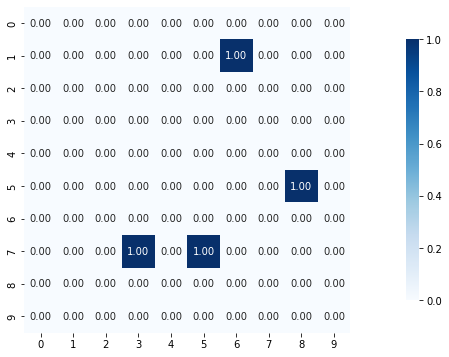

sum of mat cells: 4.0
max value is: 1.0
min value is: 0.0


In [26]:
PA = generate_PA()
show_grid(PA[0])

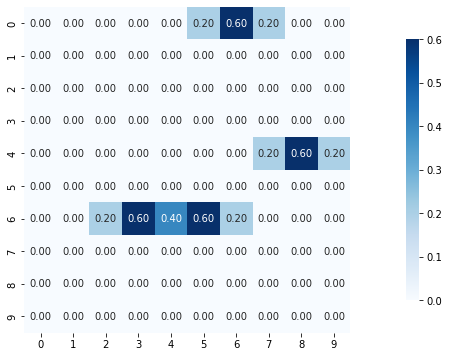

sum of mat cells: 4.0
max value is: 0.6
min value is: 0.0


In [29]:
show_grid(PA[1])

### calculating the utility matrix UA

In [38]:
def generate_UA(PA):
    T, num_rows, num_cols = PA.shape
    UA = np.zeros(PA.shape)

    for t in range(T):
        for r in range(num_rows):
            for c in range(num_cols):
                # the utility is the prevented damage for this cell multiplied by the expected agents amount
                UA[t,r,c] = (b - r) * PA[t,r,c]

    return UA

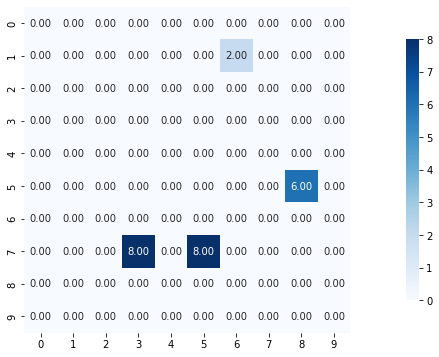

sum of mat cells: 24.0
max value is: 8.0
min value is: 0.0


In [39]:
UA = generate_UA(PA)

show_grid(UA[0])

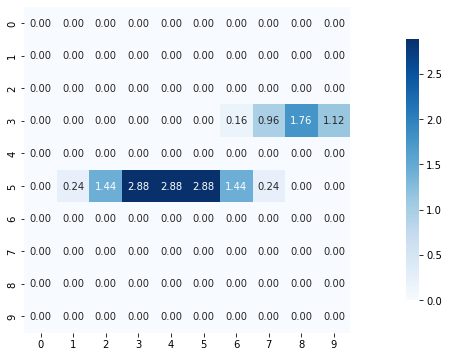

sum of mat cells: 16.0
max value is: 2.8800000000000003
min value is: 0.0


In [40]:
show_grid(UA[2])

### calculating the final utility matrix U

In [48]:
def generate_U(UA):
    T, num_rows, num_cols = PA.shape
    U = np.zeros((T,int(num_rows/2),int(num_cols/2)))
    T, num_rows, num_cols = U.shape

    for t in range(T):
        for r in range(num_rows):
            for c in range(num_cols):
                U[t][r][c] = UA[t][2*r][2*c] + UA[t][2*r+1][2*c] + UA[t][2*r][2*c+1] + UA[t][2*r+1][2*c+1]

    return U

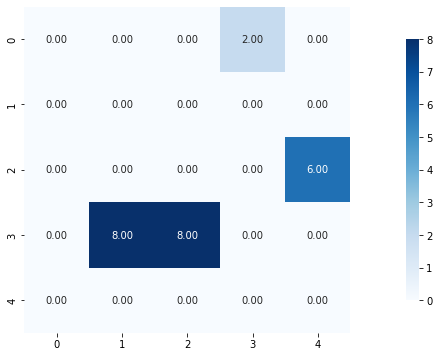

sum of mat cells: 24.0
max value is: 8.0
min value is: 0.0


In [49]:
U = generate_U(UA)

show_grid(U[0])

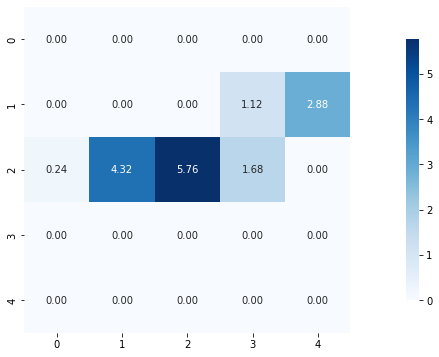

sum of mat cells: 16.0
max value is: 5.76
min value is: 0.0


In [50]:
show_grid(U[2])

## StaticLineLack
### reachability graph on one row

In [ ]:
def flow_moves(robots: List['BasicRobot'], row: float, RUM, draw=False):
    RUR = RUM[:,row,:]
    T, n_cols = RUR.shape

    g = nx.DiGraph()

    # create robots
    for robot in robots:
        g.add_node(str(robot), pos=np.array([robot.x, robot.y]), color='blue')

    # create utility cells
    for t in range(T):
        for c in range(n_cols):
            g.add_node(f'[{t},{c}]_i', pos=np.array([c, 4 + 5 * t]), color='red')
            g.add_node(f'[{t},{c}]_o', pos=np.array([c, 4 + 5 * t + 2]), color='red')
            # the weight needs to be an integer
            g.add_edge(f'[{t},{c}]_i', f'[{t},{c}]_o', weight=-int(100*RUR[t,c]), capacity=1)

    # add edges between cells
    for t in range(T-1):
        g.add_edge(f'[{t},{0}]_o',f'[{t+1},{0}]_i', weight=0, capacity=len(robots))
        g.add_edge(f'[{t},{0}]_o',f'[{t+1},{1}]_i', weight=0, capacity=len(robots))

        g.add_edge(f'[{t},{0}]_i',f'[{t+1},{0}]_i', weight=0, capacity=len(robots))
        g.add_edge(f'[{t},{0}]_i',f'[{t+1},{1}]_i', weight=0, capacity=len(robots))

        g.add_edge(f'[{t},{n_cols-1}]_o',f'[{t+1},{n_cols-1}]_i', weight=0, capacity=len(robots))
        g.add_edge(f'[{t},{n_cols-1}]_o',f'[{t+1},{n_cols-2}]_i', weight=0, capacity=len(robots))

        g.add_edge(f'[{t},{n_cols-1}]_i',f'[{t+1},{n_cols-1}]_i', weight=0, capacity=len(robots))
        g.add_edge(f'[{t},{n_cols-1}]_i',f'[{t+1},{n_cols-2}]_i', weight=0, capacity=len(robots))

        for c in range(1,n_cols-1):
            g.add_edge(f'[{t},{c}]_o',f'[{t+1},{c-1}]_i', weight=0, capacity=len(robots))
            g.add_edge(f'[{t},{c}]_o',f'[{t+1},{c}]_i', weight=0, capacity=len(robots))
            g.add_edge(f'[{t},{c}]_o',f'[{t+1},{c+1}]_i', weight=0, capacity=len(robots))

            g.add_edge(f'[{t},{c}]_i',f'[{t+1},{c-1}]_i', weight=0, capacity=len(robots))
            g.add_edge(f'[{t},{c}]_i',f'[{t+1},{c}]_i', weight=0, capacity=len(robots))
            g.add_edge(f'[{t},{c}]_i',f'[{t+1},{c+1}]_i', weight=0, capacity=len(robots))

    # for each column and robot, add edge corresponding to the arrival time
    for robot in robots:
        for c in range(n_cols):
            arrival_time = int(Point(c, row).distance_to(robot.loc) / robot.fv)
            g.add_edge(str(robot),f'[{arrival_time},{c}]_i', weight=0, capacity=1)

    # add dummy source and target to use flow
    g.add_node('s', pos=np.array([2, -2]), color='orange')
    g.add_node('t', pos=np.array([2, 5 * T + 4]), color='orange')

    for robot in robots:
        g.add_edge('s', str(robot), weight=0, capacity=1)

    for c in range(n_cols):
        g.add_edge(f'[{T-1},{c}]_o','t', weight=0, capacity=len(robots))
        g.add_edge(f'[{T-1},{c}]_i','t', weight=0, capacity=len(robots))

    # plt.xlim([0, 20])
    # plt.ylim([0, 20])
    plt.figure(3,figsize=(10,14))
    edge_labels = {k: v/100 for k, v in nx.get_edge_attributes(g,'weight').items() if v != 0}
    pos = nx.get_node_attributes(g,'pos')

    if draw:
        nx.draw(g, pos=pos,
                node_color=nx.get_node_attributes(g,'color').values(),
                with_labels=True)
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, rotate=False)
        plt.show()

    flow = nx.max_flow_min_cost(g, 's', 't')

    # delete all edges without flow
    edges_to_delete = []
    for key1, val1 in flow.items():
        for key2, val2 in val1.items():
            if val2 == 0:
                edges_to_delete.append((key1, key2))
    for key1, key2 in edges_to_delete:
        g.remove_edge(key1, key2)

    if draw:
        plt.figure(3,figsize=(10,14))
        nx.draw(g, pos=pos,
                node_color=nx.get_node_attributes(g,'color').values(),
                with_labels=True)
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, rotate=False)
        plt.show()

    return -sum(nx.get_edge_attributes(g,'weight').values())/100

print(f'expected damage avoided is {flow_moves(robots, 4, RUM, draw=True)}')

In [ ]:
T, n_rows, n_cols = RUM.shape
scores = {row : flow_moves(robots, row, RUM) for row in range(n_rows)}
row_opt = max(list(range(n_rows)), key=lambda row: scores[row])
print(row_opt)
print(scores)